In [1]:
import numpy as np
import tensorflow as tf
import gym
import time

In [2]:
EPS = 1e-8

def placeholder(dim=None):
    return tf.placeholder(dtype=tf.float32, shape=(None,dim) if dim else (None,))

def placeholders(*args):
    return [placeholder(dim) for dim in args]

def mlp(x, hidden_sizes=(32,), activation=tf.tanh, output_activation=None):
    for h in hidden_sizes[:-1]:
        x = tf.layers.dense(x, units=h, activation=activation)
    return tf.layers.dense(x, units=hidden_sizes[-1], activation=output_activation)

def get_vars(scope):
    return [x for x in tf.global_variables() if scope in x.name]

def count_vars(scope):
    v = get_vars(scope)
    return sum([np.prod(var.shape.as_list()) for var in v])

def gaussian_likelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x-mu)/(tf.exp(log_std)+EPS))**2 + 2*log_std + np.log(2*np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

def clip_but_pass_gradient(x, l=-1., u=1.):
    clip_up = tf.cast(x > u, tf.float32)
    clip_low = tf.cast(x < l, tf.float32)
    return x + tf.stop_gradient((u - x)*clip_up + (l - x)*clip_low)


"""
Policies
"""

LOG_STD_MAX = 2
LOG_STD_MIN = -20

def mlp_gaussian_policy(x, a, hidden_sizes, activation, output_activation):
    act_dim = a.shape.as_list()[-1]
    net = mlp(x, list(hidden_sizes), activation, activation)
    mu = tf.layers.dense(net, act_dim, activation=output_activation)

    log_std = tf.layers.dense(net, act_dim, activation=tf.tanh)
    log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)

    std = tf.exp(log_std)
    pi = mu + tf.random_normal(tf.shape(mu)) * std
    logp_pi = gaussian_likelihood(pi, mu, log_std)
    return mu, pi, logp_pi

def apply_squashing_func(mu, pi, logp_pi):
    mu = tf.tanh(mu)
    pi = tf.tanh(pi)
    # To avoid evil machine precision error, strictly clip 1-pi**2 to [0,1] range.
    logp_pi -= tf.reduce_sum(tf.log(clip_but_pass_gradient(1 - pi**2, l=0, u=1) + 1e-6), axis=1)
    return mu, pi, logp_pi

"""
Actor-Critics
"""
def mlp_actor_critic(x,a,x2,x_exp,a_exp,x2_exp, hidden_sizes=(400,300), activation=tf.nn.relu, 
                     output_activation=None, policy=mlp_gaussian_policy, action_space=None):
    # policy
    with tf.variable_scope('pi'):
        mu, pi, logp_pi = policy(x, a, hidden_sizes, activation, output_activation)
        mu, pi, logp_pi = apply_squashing_func(mu, pi, logp_pi)

    # make sure actions are in correct range
    action_scale = action_space.high[0]
    mu *= action_scale
    pi *= action_scale

    # vfs
    vf_mlp = lambda x : tf.squeeze(mlp(x, list(hidden_sizes)+[1], activation, None), axis=1)
    df_mlp = lambda x : tf.squeeze(mlp(x, [50,1], activation, None), axis=1)
    with tf.variable_scope('q1'):
        q1 = vf_mlp(tf.concat([x,a], axis=-1))
    with tf.variable_scope('q1', reuse=True):
        q1_pi = vf_mlp(tf.concat([x,pi], axis=-1))
    with tf.variable_scope('q2'):
        q2 = vf_mlp(tf.concat([x,a], axis=-1))
    with tf.variable_scope('q2', reuse=True):
        q2_pi = vf_mlp(tf.concat([x,pi], axis=-1))
    with tf.variable_scope('v'):
        v = vf_mlp(x)
    with tf.variable_scope('th'):
        r = df_mlp(tf.concat([x,a,x2], axis=-1))
    with tf.variable_scope('th', reuse=True):
        r_exp = df_mlp(tf.concat([x_exp,a_exp,x2_exp], axis=-1))
    with tf.variable_scope('th', reuse=True):
        eps_x = tf.random_uniform(tf.shape(x), 0.0, 1.0)
        eps_a = tf.random_uniform(tf.shape(a), 0.0, 1.0)
        eps_x2 = tf.random_uniform(tf.shape(x2), 0.0, 1.0)
        x_eps = eps_x * x_exp + (1 - eps_x) * x
        a_eps = eps_a * a_exp + (1 - eps_a) * a
        x2_eps = eps_x2 * x2_exp + (1 - eps_x2) * x2
        
        d_input = tf.concat([x_eps,a_eps,x2_eps], axis=-1) 
        r_eps = df_mlp(d_input)
        gradients = tf.gradients(r_eps, d_input)[0]
        grad_l2 = tf.sqrt(tf.reduce_sum(tf.square(gradients),axis=-1))
        gp_loss = tf.reduce_mean(tf.square(grad_l2 - 1.0)) 
        
    return mu, pi, logp_pi, q1, q2, q1_pi, q2_pi, v, r, r_exp, gp_loss

tf.reset_default_graph()

In [3]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for SAC agents.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=self.obs1_buf[idxs],
                    obs2=self.obs2_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])
    
env_name = 'HalfCheetah-v2'
env_fn = lambda : gym.make(env_name)
actor_critic=mlp_actor_critic
ac_kwargs=dict(hidden_sizes=[400, 300])
seed=0
steps_per_epoch=5000
epochs=200
replay_size=int(1e6)
gamma=0.99
polyak=0.995
lr_th=3e-4
lr_pol=5e-4
lr_val=5e-4
alpha=0.02
batch_size=100
start_steps=10000
max_ep_len=1000
save_freq=1
exp_data_size = 5000    

tf.set_random_seed(seed)
np.random.seed(seed)

env, test_env = env_fn(), env_fn()
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

# Action limit for clamping: critically, assumes all dimensions share the same bound!
act_limit = env.action_space.high[0]

# Share information about action space with policy architecture
ac_kwargs['action_space'] = env.action_space

# Inputs to computation graph
x_ph, a_ph, x2_ph, x_exp_ph, a_exp_ph, x2_exp_ph, r_ph, d_ph = placeholders(obs_dim, act_dim, obs_dim, obs_dim, act_dim, obs_dim, None, None)

# Main outputs from computation graph
with tf.variable_scope('main'):
    mu, pi, logp_pi, q1, q2, q1_pi, q2_pi, v, th, th_exp, gp_loss = actor_critic(x_ph, a_ph, x2_ph, x_exp_ph, a_exp_ph, x2_exp_ph, **ac_kwargs)

# Target value network
with tf.variable_scope('target'):
    _, _, _, _, _, _, _, v_targ, _, _, _  = actor_critic(x2_ph, a_ph, x2_ph, x_exp_ph, a_exp_ph, x2_exp_ph, **ac_kwargs)

# Experience buffer
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)
exp_replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=exp_data_size)

# Load Expert's Demos
demo_list = np.load('exp_'+env_name+'.npy')
for demo in demo_list:
    for t in range(len(demo['rew'])):
        o = demo['obs'][t]
        a = demo['act'][t]
        r = demo['rew'][t]
        d = demo['done'][t]
        o2 = demo['obs'][t+1]
        exp_replay_buffer.store(o,a,r,o2,d)
        if exp_data_size < exp_replay_buffer.size:
            break
    if exp_data_size < exp_replay_buffer.size:
        break

# Count variables
var_counts = tuple(count_vars(scope) for scope in 
                   ['main/th', 'main/pi', 'main/q1', 'main/q2', 'main/v', 'main'])
print(('\nNumber of parameters: \t th: %d, \t pi: %d, \t' + \
       'q1: %d, \t q2: %d, \t v: %d, \t total: %d\n')%var_counts)

# Min Double-Q:
min_q_pi = tf.minimum(q1_pi, q2_pi)

# Targets for Q and V regression
r_backup = tf.stop_gradient(tf.log(tf.sigmoid(th)+1e-6) - tf.log(1-tf.sigmoid(th)+1e-6))
q_backup = tf.stop_gradient(r_backup + gamma*(1-d_ph)*v_targ)
v_backup = tf.stop_gradient(min_q_pi - alpha * logp_pi)

# discriminator losses
th_loss = tf.reduce_mean(tf.log(tf.sigmoid(th)+1e-6)) + tf.reduce_mean(tf.log(1-tf.sigmoid(th_exp)+1e-6)) + 10.*gp_loss
gen_acc = tf.reduce_mean(tf.cast(tf.sigmoid(th) < 0.5, tf.float32))
exp_acc = tf.reduce_mean(tf.cast(tf.sigmoid(th_exp) > 0.5, tf.float32))

# Soft actor-critic losses
pi_loss = tf.reduce_mean(alpha * logp_pi - q1_pi)
q1_loss = 0.5 * tf.reduce_mean((q_backup - q1)**2)
q2_loss = 0.5 * tf.reduce_mean((q_backup - q2)**2)
v_loss = 0.5 * tf.reduce_mean((v_backup - v)**2)
value_loss = q1_loss + q2_loss + v_loss

th_optimizer = tf.train.AdamOptimizer(learning_rate=lr_th)
train_th_op = th_optimizer.minimize(th_loss, var_list=get_vars('main/th'))

# Policy train op 
# (has to be separate from value train op, because q1_pi appears in pi_loss)
pi_optimizer = tf.train.AdamOptimizer(learning_rate=lr_pol)
train_pi_op = pi_optimizer.minimize(pi_loss, var_list=get_vars('main/pi'))

# Value train op
# (control dep of train_pi_op because sess.run otherwise evaluates in nondeterministic order)
value_optimizer = tf.train.AdamOptimizer(learning_rate=lr_val)
value_params = get_vars('main/q') + get_vars('main/v')
with tf.control_dependencies([train_pi_op]):
    train_value_op = value_optimizer.minimize(value_loss, var_list=value_params)

# Polyak averaging for target variables
# (control flow because sess.run otherwise evaluates in nondeterministic order)
with tf.control_dependencies([train_value_op]):
    target_update = tf.group([tf.assign(v_targ, polyak*v_targ + (1-polyak)*v_main)
                              for v_main, v_targ in zip(get_vars('main'), get_vars('target'))])

# All ops to call during one training step
step_ops = [tf.reduce_mean(r_backup), th_loss, gen_acc, exp_acc, pi_loss, q1_loss, q2_loss, v_loss, q1, q2, v, logp_pi, 
            train_th_op, train_pi_op, train_value_op, target_update]

# Initializing targets to match main variables
target_init = tf.group([tf.assign(v_targ, v_main)
                          for v_main, v_targ in zip(get_vars('main'), get_vars('target'))])

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(target_init)

def get_action(o, deterministic=False):
    act_op = mu if deterministic else pi
    return sess.run(act_op, feed_dict={x_ph: o.reshape(1,-1)})

def test_agent(n=10):
    global sess, mu, pi, q1, q2, q1_pi, q2_pi
    ep_ret_list = []
    for j in range(n):
        o, r, d, ep_ret, ep_len = test_env.reset(), 0, False, 0, 0
        while not(d or (ep_len == max_ep_len)):
            # Take deterministic actions at test time 
            o, r, d, _ = test_env.step(get_action(o, True))
            ep_ret += r
            ep_len += 1
        ep_ret_list.append(ep_ret)
    return ep_ret_list

start_time = time.time()
o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
total_steps = steps_per_epoch * epochs

ep_ret_list = []

# Main loop: collect experience in env and update/log each epoch
for t in range(total_steps):

    """
    Until start_steps have elapsed, randomly sample actions
    from a uniform distribution for better exploration. Afterwards, 
    use the learned policy. 
    """
    if t > start_steps:
        a = get_action(o)
    else:
        a = env.action_space.sample()

    # Step the env
    o2, r, d, _ = env.step(a)
    ep_ret += r
    ep_len += 1

    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state)
    d = False if ep_len==max_ep_len else d

    # Store experience to replay buffer
    replay_buffer.store(o, a, r, o2, d)

    # Super critical, easy to overlook step: make sure to update 
    # most recent observation!
    o = o2

    if d or (ep_len == max_ep_len):
        """
        Perform all SAC updates at the end of the trajectory.
        This is a slight difference from the SAC specified in the
        original paper.
        """
        for j in range(ep_len):
            batch_exp = exp_replay_buffer.sample_batch(batch_size)
            batch = replay_buffer.sample_batch(batch_size)
            feed_dict = {x_ph: batch['obs1'],
                         x2_ph: batch['obs2'],
                         a_ph: batch['acts'],
                         x_exp_ph: batch_exp['obs1'],
                         x2_exp_ph: batch_exp['obs2'],
                         a_exp_ph: batch_exp['acts'],
                         d_ph: batch['done'],
                        }
            outs = sess.run(step_ops, feed_dict)
            if np.isnan(outs[1]):
                print(outs)
                return
        o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0


    # End of epoch wrap-up
    if t > 0 and t % steps_per_epoch == 0:
        epoch = t // steps_per_epoch

        # Test the performance of the deterministic version of the agent.
        test_ep_ret = test_agent()
        ep_ret_list.append(np.mean(test_ep_ret))
        print('Test Ret:%f'%np.mean(test_ep_ret))
        print(outs[0],outs[1],outs[2],outs[3])


Number of parameters: 	 th: 2101, 	 pi: 131112, 	q1: 130201, 	 q2: 130201, 	 v: 127801, 	 total: 521416

Test Ret:-544.083815
-13.076596 -25.435877 1.0 0.99
Test Ret:-662.477766
-13.346921 -25.686169 1.0 0.97
Test Ret:-367.569999
-12.676209 -23.267633 1.0 0.96
Test Ret:-348.833513
-12.500965 -22.560997 1.0 0.98
Test Ret:-419.142964
-12.4812155 -23.077806 1.0 0.99
Test Ret:-484.730874
-12.489636 -22.213667 1.0 0.97
Test Ret:-519.830677
-12.277827 -22.182322 1.0 0.97
Test Ret:-316.488560
-12.5741625 -22.066914 1.0 0.96
Test Ret:-355.900565
-12.584404 -21.831495 1.0 0.97
Test Ret:-282.848814
-12.358701 -20.968077 1.0 0.91
Test Ret:-176.959518
-12.396253 -21.743328 1.0 0.95
Test Ret:-280.951335
-12.249642 -21.868357 1.0 0.98
Test Ret:-32.884961
-12.422864 -22.373232 1.0 0.98
Test Ret:518.775262
-12.591826 -21.926369 1.0 0.97
Test Ret:27.727462
-12.268072 -21.688602 1.0 0.97
Test Ret:428.116443
-12.08482 -21.2314 1.0 0.95
Test Ret:822.685972
-11.859397 -20.695068 1.0 0.93
Test Ret:1469.450

Test Ret:8638.888159
9.603804 -13.799738 0.09 1.0
Test Ret:8683.167552
9.742529 -13.652136 0.1 1.0
Test Ret:9154.242246
9.914891 -13.967934 0.09 1.0
Test Ret:8726.820085
11.001521 -13.894973 0.07 1.0
Test Ret:8418.865852
10.286249 -13.87238 0.07 1.0
Test Ret:8899.376540
11.088222 -13.708492 0.06 1.0
Test Ret:8939.560142
10.81467 -13.877515 0.05 1.0
Test Ret:8044.970253
10.971548 -13.888374 0.05 1.0
Test Ret:8570.097466
10.6203575 -13.993082 0.07 1.0
Test Ret:7669.111215
11.266921 -13.702807 0.04 1.0
Test Ret:8329.099440
11.324352 -13.791541 0.04 1.0
Test Ret:8564.282530
11.477974 -13.775866 0.03 1.0
Test Ret:8590.292252
12.018682 -13.693421 0.0 1.0
Test Ret:8112.198744
11.117714 -13.876783 0.06 1.0
Test Ret:8681.307521
11.16032 -13.887381 0.05 1.0
Test Ret:7972.052468
10.470177 -14.256931 0.1 1.0
Test Ret:8358.610406
11.955889 -13.918425 0.03 1.0
Test Ret:8342.138600
11.59726 -13.932798 0.04 1.0
Test Ret:8333.750740
10.848974 -13.946008 0.04 1.0
Test Ret:8433.880518
11.695322 -13.79719

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

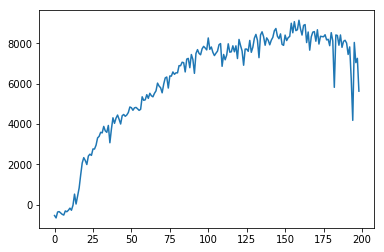

In [5]:
plt.plot(ep_ret_list)